# Exploratory Data Analysis

In [13]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
# lightkurve
#import lightkurve as lk

In [3]:
# Data
df = pd.read_csv("031381302.csv")

# Check
df.shape
df.head

<bound method NDFrame.head of               time  flux  flux_err  timecorr  cadenceno  centroid_col  \
0      1437.978646   NaN       NaN -0.000371     151577           NaN   
1      1437.980034   NaN       NaN -0.000371     151578           NaN   
2      1437.981423   NaN       NaN -0.000371     151579           NaN   
3      1437.982812   NaN       NaN -0.000371     151580           NaN   
4      1437.984201   NaN       NaN -0.000371     151581           NaN   
...            ...   ...       ...       ...        ...           ...   
17714  1464.278524   NaN       NaN -0.000482     170513           NaN   
17715  1464.279913   NaN       NaN -0.000482     170514           NaN   
17716  1464.281302   NaN       NaN -0.000482     170515           NaN   
17717  1464.282691   NaN       NaN -0.000482     170516           NaN   
17718  1464.285468   NaN       NaN -0.000482     170518           NaN   

       centroid_row  sap_flux  sap_flux_err  sap_bkg  ...  psf_centr1  \
0               NaN 

In [11]:
# Basic cleanup
pdcsap = df[["time", "pdcsap_flux"]]
pdcsap.shape[0]#; pdcsap.head

17719

In [12]:
nans = pdcsap["pdcsap_flux"].isna().sum()
print([nans, pdcsap.shape[0] - nans])

[686, 17033]


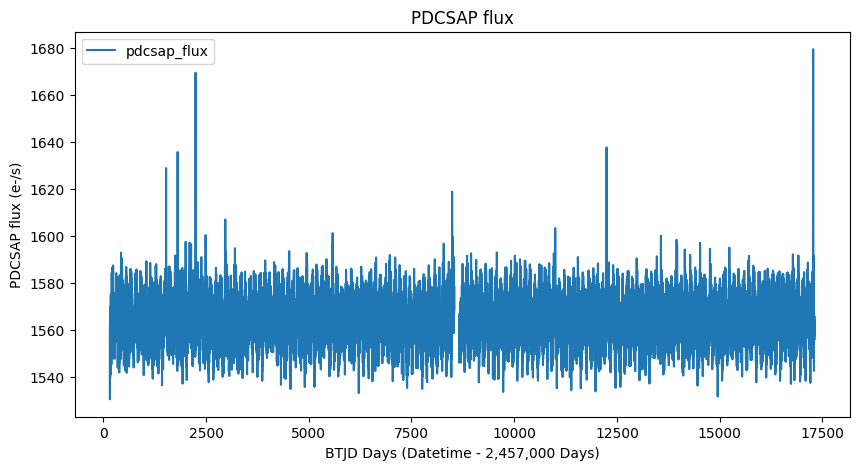

In [17]:
## Plot
pdcsap.set_index("time")

pdcsap.plot(y = "pdcsap_flux", title = "PDCSAP flux", figsize = (10, 5))
plt.xlabel("BTJD Days (Datetime - 2,457,000 Days)")
plt.ylabel("PDCSAP flux (e-/s)")
plt.show()

In [ ]:
#rah